# Load modules

In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Create `anadata` object

First, an `anndata` object was created using objects outputed from R. 

In [2]:
X = io.mmread("/Users/wenjunliu/DHT_fibroblast_snRNAseq/output/counts.mtx")
adata = anndata.AnnData(
    X = X.transpose().tocsr()
)

In [3]:
# load cell metadata:
cell_meta = pd.read_csv("/Users/wenjunliu/DHT_fibroblast_snRNAseq/output/metadata.csv")

# load gene names:
with open("/Users/wenjunliu/DHT_fibroblast_snRNAseq/output/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()
    
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

In [4]:
# load dimensional reduction:
pca = pd.read_csv("/Users/wenjunliu/DHT_fibroblast_snRNAseq/output/pca.csv")
pca.index = adata.obs.index

# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

## UMAP plot
The UMP plot was replciated here to confirm that the dimensional reduction information has been successfully transferred. 

In [5]:
# Convert cluster labels to categorical
adata.obs['clusters'] = adata.obs['cluster'].astype('category')

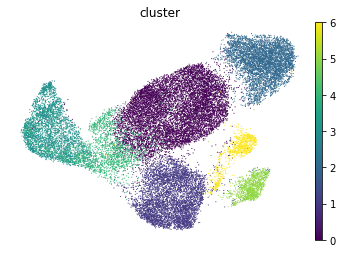

In [6]:
sc.pl.umap(adata, color=['cluster'], 
           frameon=False)

For consistence, the cluster colored used in R were also used here.

In [7]:
# replicate ggplot2 cluster colors
cluster_colors = ['#F8766D', '#C49A00', '#53B400', '#00C094', '#00B6EB', '#A58AFF', '#FB61D7']
adata.uns['cluster_colors'] = cluster_colors

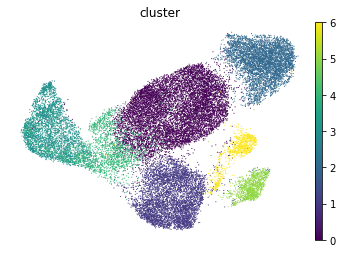

In [8]:
sc.pl.umap(adata, color=['cluster'], 
           frameon=False)

# Read in Velocyto Output
Velocyto was used to construct the spliced and unspliced count matrices for each sample. Velocyto created a separate spliced and unspliced matrix for each sample, so we first have to merge the different samples into one object. Additionally,

In [9]:
import scvelo as scv
import cellrank as cr

In [10]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

In [11]:
test = scv.read('velocyto_output/MF43_DHT.loom', cache=True)
test

/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3859 × 36601
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [12]:
# load loom files for spliced/unspliced matrices for each sample:
MF43_DHT = scv.read('velocyto_output/MF43_DHT.loom', cache=True)
MF43_VEH = scv.read('velocyto_output/MF43_VEH.loom', cache=True)
MF61_DHT = scv.read('velocyto_output/MF61_DHT.loom', cache=True)
MF61_VEH = scv.read('velocyto_output/MF61_VEH.loom', cache=True)

/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
# velocyto changed cell barcode. Rename barcode to match to metadata
barcodes = [bc.split(':')[1] + '-1_1' for bc in MF43_DHT.obs.index.tolist()]
MF43_DHT.obs.index = barcodes

barcodes = [bc.split(':')[1] + '-1_2' for bc in MF43_VEH.obs.index.tolist()]
MF43_VEH.obs.index = barcodes

barcodes = [bc.split(':')[1] + '-1_3' for bc in MF61_DHT.obs.index.tolist()]
MF61_DHT.obs.index = barcodes

barcodes = [bc.split(':')[1] + '-1_4' for bc in MF61_VEH.obs.index.tolist()]
MF61_VEH.obs.index = barcodes

In [14]:
MF43_DHT.var_names_make_unique()
MF43_VEH.var_names_make_unique()
MF61_DHT.var_names_make_unique()
MF61_VEH.var_names_make_unique()

In [15]:
merged = MF43_DHT.concatenate([MF43_VEH, MF61_DHT, MF61_VEH])

In [16]:
# merge matrices into the original adata object
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(merged)
adata = scv.utils.merge(adata, merged)

In [17]:
adata

AnnData object with n_obs × n_vars = 26491 × 27373
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample', 'patient', 'Treatment', 'RNA_snn_res.0.3', 'seurat_clusters', 'cluster', 'hpca_pred', 'CAF_pred', 'label_check', 'barcode', 'UMAP_1', 'UMAP_2', 'clusters', 'sample_batch', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'cluster_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


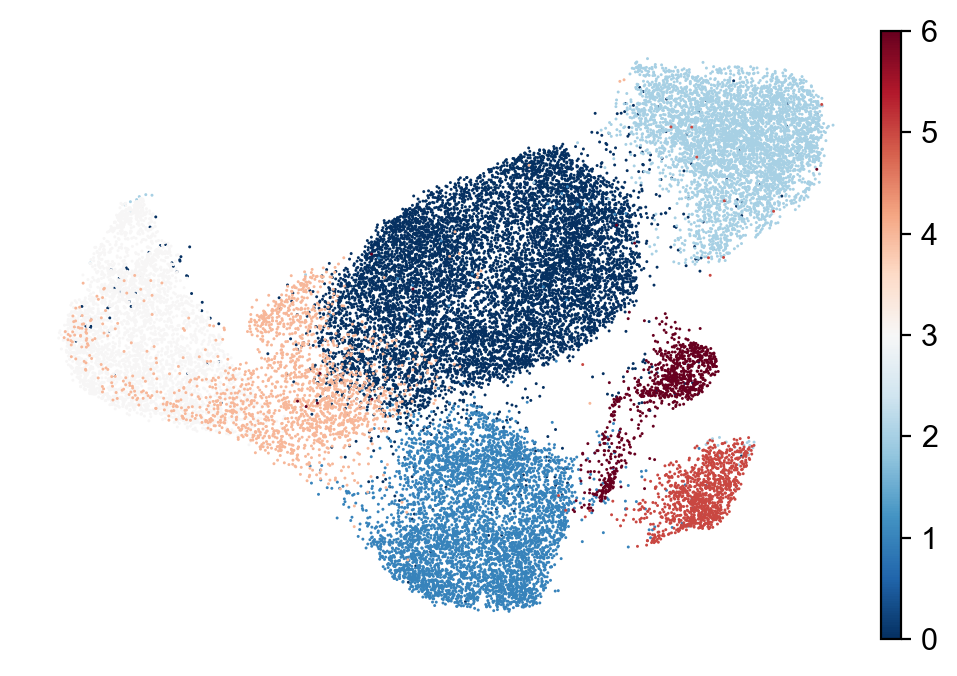

In [18]:
# plot umap to check
sc.pl.umap(adata, color='cluster', frameon=False, 
           legend_loc='on data', title='', 
           #save='_clusters.pdf'
          )

# Compute RNA velocity using scVelo
First, the spliced vs unspliced proportions in each sample were inspected. The variations are relatively small, except for sample MF61_DHT, which had a larger proportion of spliced transcripts then the other three samples.

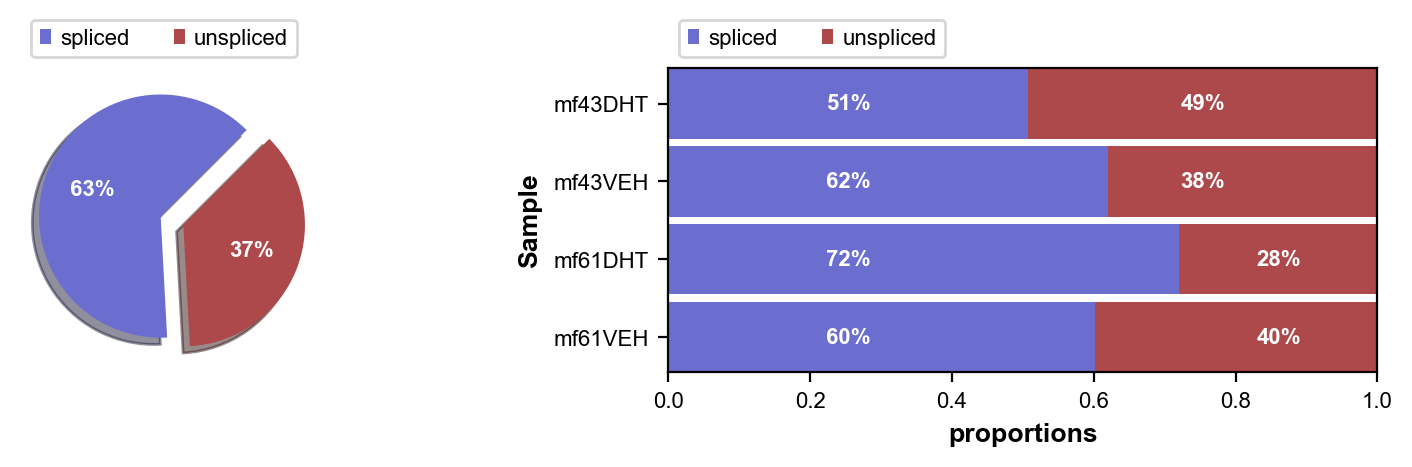

In [19]:
scv.pl.proportions(adata, groupby='Sample'
                   #, save = 'prop.png', fontsize = 16, dpi = 300
                  )

In [20]:
# pre-process
scv.pp.filter_and_normalize(adata, enforce = True)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:22) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
# compute velocity
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.


/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:11:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:44) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [22]:
#print(adata.layers['velocity'])

In [23]:
# note this step requires numpy to be downgraded to 1.23.2
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/10 cores)


/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:18) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


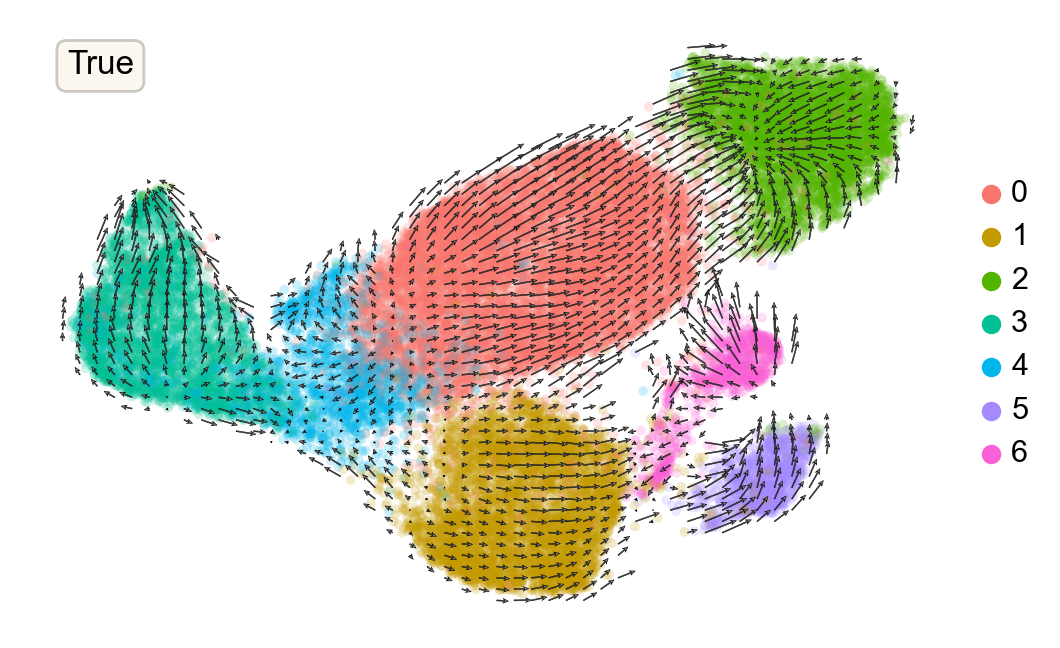

In [30]:
# visualise velocity fields
scv.pl.velocity_embedding_grid(adata, basis='umap', color='cluster', 
                               #save = 'velocity.png', dpi = 300, fontsize = 16,
                                title='', scale=0.3, legend_loc= 'right margin')

# Downstream analysis


computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:51) --> added 
    'latent_time', shared time (adata.obs)


/Users/wenjunliu/opt/anaconda3/envs/scRNA_seq/lib/python3.11/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


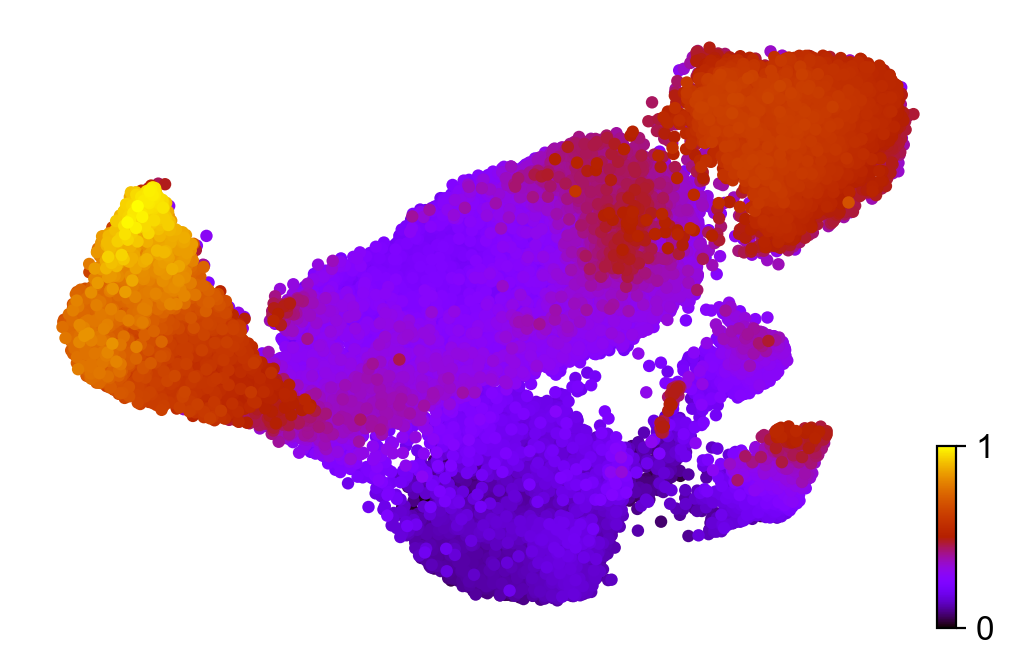

In [25]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', 
               size=80, title = '',legend_loc= 'right margin',
               #save = 'latent_time.png', dpi = 300, legend_fontsize = 16
              )

In [39]:
adata.uns['patient_colors'] = ['#584B9F', '#A71B4B']
adata.uns['Treatment_colors'] = ['#C21807', '#CCCCCC']

saving figure to file ./figures/scvelo_heatmap_heatmap.png


ValueError: 'bboxes' cannot be empty

<Figure size 800x400 with 5 Axes>

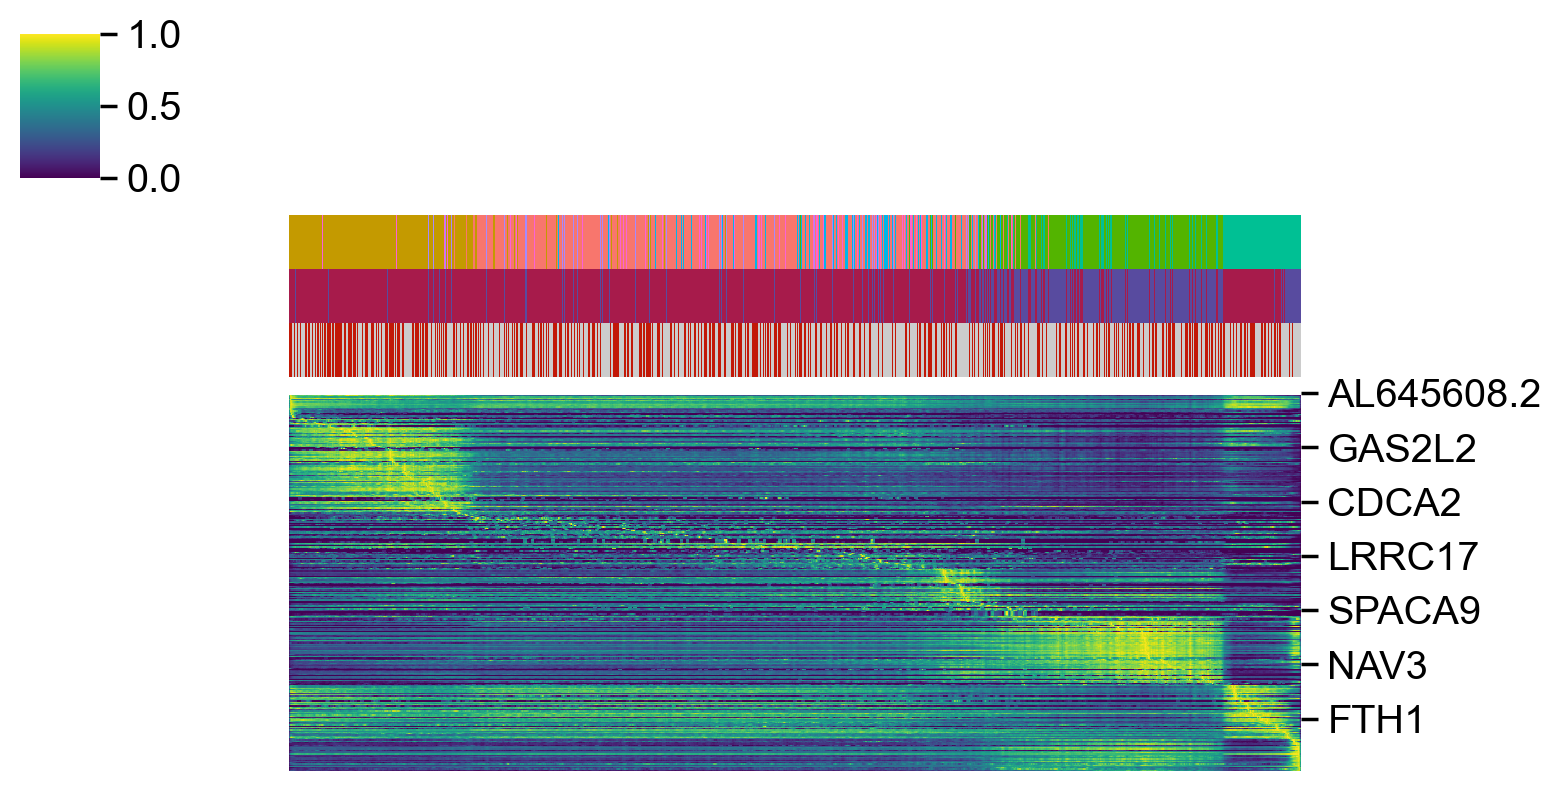

In [41]:
#top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', 
               col_color=['cluster','patient', 'Treatment'], n_convolve=100, colors_ratio = 0.08, 
              save = 'heatmap.png', font_scale = 1.3, colorbar = True, cbar_pos = (0, 0, 0.8, 1)
              )